In [22]:
path = "../results/sst-5/llama/CAPO/hyper_co/benchmark_experiment_sst-5_llama_CAPO_44/97e64b56c82ab0fd2711609788ba2ca5bd7cfed43a51ce9ef37ae43a6b291866/step_results.csv"

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
df = pd.read_csv(path)
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm
0,1,2025-03-15 00:23:12.493495,382.923345,0.521135,What sentiment does this movie review convey? ...,3639,1210,892378,170311
1,1,2025-03-15 00:23:12.493495,382.923345,0.520873,Examine the movie review and determine its sen...,3639,1210,892378,170311
2,1,2025-03-15 00:23:12.493495,382.923345,0.519277,Evaluate the emotional content of the followin...,3639,1210,892378,170311
3,1,2025-03-15 00:23:12.493495,382.923345,0.506667,How would you describe the sentiment of this m...,3639,1210,892378,170311
4,1,2025-03-15 00:23:12.493495,382.923345,0.506305,Movie sentiment classification task: What sent...,3639,1210,892378,170311
...,...,...,...,...,...,...,...,...,...
265,27,2025-03-15 01:24:27.988840,180.746402,0.539448,Examine the movie review and determine its sen...,4885,2346,492843,76397
266,27,2025-03-15 01:24:27.988840,180.746402,0.539147,Movie sentiment analysis task: Analyze the sen...,4885,2346,492843,76397
267,27,2025-03-15 01:24:27.988840,180.746402,0.538735,Movie sentiment analysis task: Evaluate the mo...,4885,2346,492843,76397
268,27,2025-03-15 01:24:27.988840,180.746402,0.538112,Movie sentiment analysis task: Evaluate the mo...,4885,2346,492843,76397


In [6]:
len(df["prompt"].unique())

37

In [25]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,score_max
0,1,382.923345,0.507767,3639.0,1210.0,892378.0,170311.0,0.521135
1,2,174.385437,0.517068,3866.0,1392.0,397844.0,85824.0,0.550422
2,3,222.673806,0.523253,3863.0,1466.0,537809.0,134730.0,0.550422
3,4,186.191135,0.526660,3976.0,1515.0,467029.0,107264.0,0.550422
4,5,169.020152,0.527436,4398.0,1894.0,463319.0,78901.0,0.550422
5,6,154.495692,0.528223,4300.0,1855.0,340267.0,95908.0,0.550422
6,7,171.754605,0.529876,4481.0,1959.0,363753.0,112266.0,0.550422
7,8,148.461000,0.529876,4266.0,1786.0,331207.0,87991.0,0.550422
8,9,163.620453,0.535087,4294.0,1869.0,418189.0,73563.0,0.550422
9,10,92.966711,0.535889,4609.0,1952.0,221920.0,38590.0,0.550422


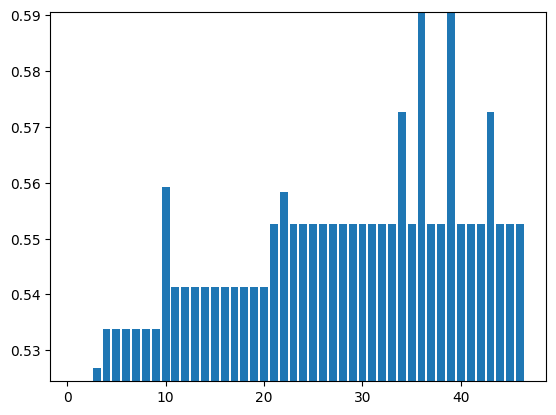

In [9]:
# plot token count vs step and adapt y-axis to min and max
column = "score_max"
plt.bar(df_grouped["step"], df_grouped[column])
plt.ylim(df_grouped[column].min(), df_grouped[column].max())
plt.show();

### Analyze best prompts per step

In [10]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "test_score")).reset_index(drop=True)
df_best

KeyError: 'test_score'

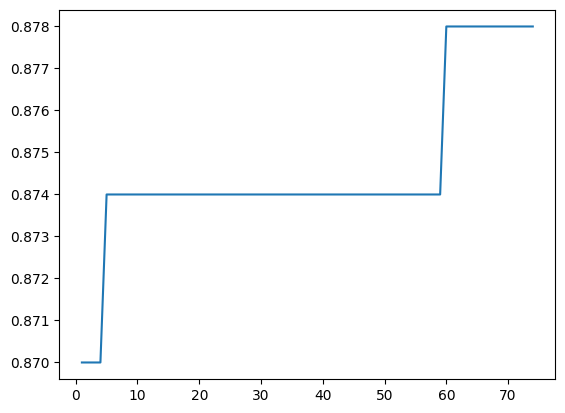

In [95]:
# max a line plot of the best score vs step
plt.plot(df_best["step"], df_best["test_score"])

## Analyze Racing

In [ ]:
# load the prompt scores per block
path = r"C:/Users/schla/git/capo/results/results/sst-5/mistral/CAPO/seed44/benchmark_experiment_sst-5_mistral_CAPO_44/cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521/prompt_scores_63.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9
0,Analyze the emotional tone and sentiment of th...,0.53,0.53,0.40,0.47,0.57,0.27,NaN,NaN,NaN,NaN
1,Analyze the emotional tone and sentiment of th...,0.63,0.67,0.33,0.57,0.63,0.47,0.50,0.53,0.63,0.5
2,Analyze the emotional tone and sentiment of th...,0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Analyze the emotional tone and sentiment of th...,0.53,0.60,0.47,0.50,0.53,0.43,0.47,0.53,0.40,NaN
4,Analyze the emotional tone and sentiment of th...,0.53,0.57,0.43,0.53,0.60,0.37,0.50,0.43,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
243,new prompt\n\nInput: and it marks him as one o...,0.57,0.57,0.53,0.50,0.47,0.40,0.27,0.47,0.43,NaN
244,new prompt\n\nInput: consider this review life...,0.57,0.57,0.33,0.50,0.47,0.40,0.33,0.40,0.37,NaN
245,new prompt\n\nInput: dreary tale of middle-cla...,0.43,0.53,0.43,0.53,0.40,0.37,0.23,NaN,NaN,NaN
246,"new prompt\n\nInput: it is depressing , ruthle...",0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# load the prompt scores per block
path = r"C:/Users/schla/git/capo/results/local/benchmark_experiment_sst5_CAPO_44/cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521/prompt_scores_1.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5
0,Analyze the emotional tone in each movie revie...,0.47,0.70,0.67,0.47,0.53,NaN
1,Analyze the provided movie review and identify...,0.47,0.73,0.73,0.57,0.70,0.53
2,Analyze the sentiment expressed in the given m...,0.40,NaN,NaN,NaN,NaN,NaN
3,Analyze the sentiment of each movie review in ...,0.40,0.70,0.63,0.43,NaN,NaN
4,Assess the tone of the provided film review an...,0.57,0.67,0.57,0.50,0.67,0.57
5,Determine the emotional tone of the following ...,0.43,0.63,NaN,NaN,NaN,NaN
6,Examine the following film critique and determ...,0.53,0.67,0.67,0.50,0.60,0.63
7,Movie Review Sentiment Categorization Task: As...,0.50,0.63,0.70,0.63,0.60,0.50
8,Movie review sentiment classification task: Fr...,0.40,0.67,0.57,NaN,NaN,NaN
9,Quick sentiment check - is this movie review v...,0.50,0.73,0.73,0.53,0.60,0.47


In [ ]:
# load the prompt scores per block
path = r"C:/Users/schla/git/capo/results/local/benchmark_experiment_sst5_CAPO_44/cbc743c08d16c22ec7791bac5008d8c2381cb9c1cee4856ddc2f2fef761ef521/prompt_scores_2.csv"

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,0,1,2,3,4,5
0,Analyze the emotional tone in each movie revie...,0.47,0.70,0.67,0.47,0.53,NaN
1,Analyze the provided movie review and identify...,0.47,0.73,0.73,0.57,0.70,0.53
2,Analyze the sentiment expressed in the given m...,0.40,NaN,NaN,NaN,NaN,NaN
3,Analyze the sentiment of each movie review in ...,0.40,0.70,0.63,0.43,NaN,NaN
4,Assess the tone of the provided film review an...,0.57,0.67,0.57,0.50,0.67,0.57
5,Determine the emotional tone of the following ...,0.43,0.63,NaN,NaN,NaN,NaN
6,Examine the following film critique and determ...,0.53,0.67,0.67,0.50,0.60,0.63
7,Examine the given movie review to determine it...,0.47,0.70,0.67,0.60,0.53,0.53
8,Examine the given movie review to determine it...,0.60,0.70,0.70,0.43,NaN,NaN
9,Movie Review Sentiment Categorization Task: As...,0.50,0.63,0.70,0.63,0.60,0.50


In [ ]:
# best prompt
df[df["score"] == df["score"].max()].T

,0
step,1
timestamp,2025-03-13 22:26:22.354103
time_elapsed,112.864839
score,0.596647
prompt,Evaluate the emotional content of the followin...
input_tokens_meta_llm,1441
output_tokens_meta_llm,552
input_tokens_downstream_llm,107364
output_tokens_downstream_llm,33547
